# Preparation

data classes, general functions

In [380]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
#Used for sorted insertion in list 
import bisect

In [381]:
KNN_TRAIN = "./mnist_small/train.csv"
KNN_TEST = "./mnist_small/test.csv"

names = ["label"] + [f"Pix {i}" for i in range(28*28)]

train_pd = pd.read_csv(KNN_TRAIN, names=names)
test_pd = pd.read_csv(KNN_TEST, names=names)

In [382]:
train_pd

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [383]:
test_pd

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [384]:
def visualize_image(mnist_array: np.array):
    """Visualize the given flattened image from the mnist dataset with its expected label"""
    label = mnist_array[0]
    image = mnist_array[1:].reshape(28, 28)

    fig = plt.figure()
    plt.title(f"Handwritten [{label}]") 
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()
    

class KnnClassifier:
    """Class encapsulating the logic of the KNN algorithm"""
    labels: pd.DataFrame
    data: pd.DataFrame
    k: int

    def __init__(self, k: int) -> None:
        """Init the KNN classifier. Needs a vlaue for K (The neighboors to consider)"""
        self.k = k

    def distance_pix_intensity(self, image1: np.array, image2: np.array):
        """Compute the distance as the difference in intensity level pixel-wise"""
        #use numpy functions as they are made to be efficient with vecotrized input
        return np.sum(np.abs(np.subtract(image1, image2)))

    def train(self, train_df: pd.DataFrame):
        self.labels = train_df.pop('label')
        self.data = train_df
        print(f"KNN prepared with {len(self.data)} data")
    
    def classify_single_verbose(self, image_array: np.array) -> None:
        """Classify an image by performing the KNN on the training dataset. 
        Don't return anything, focus on displaying steps to verify function execution"""
        #Assume the MNIST format, extract expected label
        expected_label = image_array[0]
        print(f"Trying to correctly classify image with expected label [{expected_label}]")

        image = image_array[1:]
        #Compute distance over each DF line
        distances = []
        print(f"Computing distances...")
        for i, row in self.data.iterrows():
            distance = self.distance_pix_intensity(image, row)
            image_label = self.labels.loc[i]
            #Sorted insertion for optimization
            bisect.insort_left(distances, (distance, image_label))
        print(f"Sorted tuple of (distances, labels): {distances}")

        #As list is sorted by distance, finding the neihbourhood is both trivial and quick
        neighbourhood = distances[:self.k]
        labels = [label for _, label in neighbourhood]
        print(f"Significant labels with k={self.k}: {labels}")

        sorted_freq_labels = Counter(labels).most_common()
        print(f"Count: {sorted_freq_labels}")

        #Trival case: only one class
        if len(sorted_freq_labels) == 1:
            classified_label = sorted_freq_labels[0][0]
        #In case of tie: fallback to K=1
        elif sorted_freq_labels[0][1] == sorted_freq_labels[1][1]:
            print(f"Detected draw with at least two classes, fallback to k=1")
            classified_label = neighbourhood[0][1]
        #else simply take most common
        else:
            classified_label = sorted_freq_labels[0][0]
        
        print(f"Classified image as: {classified_label}")

    def classify_single(self, image_array: np.array, verbose: bool = False) -> int:
        """Classify an image by performing the KNN on a """
        #Assume the MNIST format, extract expected label
        expected_label = image_array[0]
        image = image_array[1:]

        #Compute distance over each DF line
        distances = []
        for i, row in self.data.iterrows():
            distance = self.distance_pix_intensity(image, row)
            image_label = self.labels.loc[i]
            #Sorted insertion for optimization
            bisect.insort_left(distances, (distance, image_label))

        #As list is sorted by distance, finding the neihbourhood is both trivial and quick
        neighbourhood = distances[:self.k]
        labels = [label for _, label in neighbourhood]
        sorted_freq = Counter(labels).most_common()

    def classify_dataset(self, dataset: pd.DataFrame):
        pass

# Manual Test
First, let's try our solution and see with a few numbers if the mecanism is in place

In [385]:
train_pd

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [386]:
sample = train_pd.sample()
sample

,label,Pix 0,Pix 1,Pix 2,Pix 3,Pix 4,Pix 5,Pix 6,Pix 7,Pix 8,...,Pix 774,Pix 775,Pix 776,Pix 777,Pix 778,Pix 779,Pix 780,Pix 781,Pix 782,Pix 783
767,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [387]:
sample_np = sample.to_numpy()[0]
sample_np

array([  8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         7,  45,   0,   0,   7, 136, 255, 254, 197,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

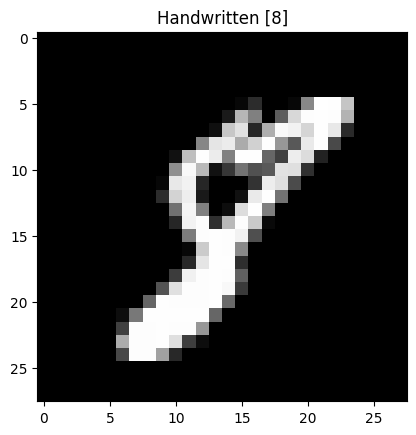

In [388]:
visualize_image(sample_np)

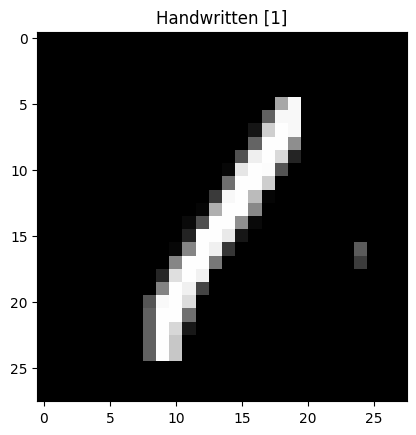

In [389]:
visualize_image(test_pd.sample().to_numpy()[0])

In [390]:
knnClassifier = KnnClassifier(k = 5)
knnClassifier.train(train_pd)

KNN prepared with 1000 data


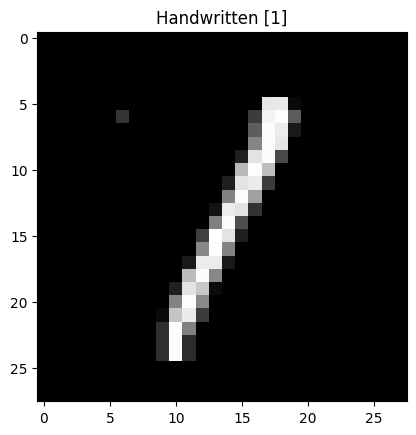

In [391]:
test_image = test_pd.sample().to_numpy()[0]
visualize_image(test_image)

In [392]:
knnClassifier.classify_single_verbose(test_image)

Trying to correctly classify image with expected label [1]
Computing distances...
Sorted tuple of (distances, labels): [(3648, 1), (4763, 1), (5519, 1), (5680, 1), (5765, 1), (5815, 1), (6382, 1), (6488, 1), (6539, 1), (6635, 1), (6736, 1), (6994, 1), (7065, 1), (7119, 1), (7355, 1), (7446, 1), (7637, 1), (7944, 1), (7963, 1), (7977, 1), (8206, 1), (8275, 1), (8451, 1), (8529, 1), (8556, 1), (8724, 1), (9064, 1), (9112, 1), (9177, 1), (9452, 1), (9465, 1), (9819, 1), (10261, 1), (10265, 1), (10470, 1), (11051, 1), (11134, 1), (11147, 1), (11226, 1), (11272, 1), (11301, 1), (11320, 1), (11340, 1), (11340, 1), (11651, 1), (11801, 7), (12342, 1), (12348, 1), (12528, 1), (12688, 1), (12762, 1), (12899, 9), (12908, 1), (12948, 4), (12970, 1), (13043, 1), (13156, 1), (13226, 1), (13236, 1), (13400, 1), (13400, 1), (13448, 1), (13917, 1), (13942, 1), (13953, 1), (14061, 1), (14082, 1), (14158, 1), (14332, 6), (14436, 1), (14439, 1), (14526, 1), (14711, 1), (14817, 1), (14821, 1), (14834, 1), 